In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

import sys
import os
import interpretability.core.utils as interp

import utils.file_management as fm
import utils.model_utils as model_utils

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 10,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [3]:
run = 2

In [7]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# run = fm.get_latest_run()
model, model_info, config = model_utils.load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print number of parameters and important metadata
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Using cpu device
Total number of parameters: 292


In [8]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']


In [9]:
num_sequences = 300
N=10
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences, min_count=N)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

Analyzing 300 sequences:
['RRRRRR', 'LLLLLL', 'RRRRRr', 'LLLLLl', 'RRRRrR', 'LLLLlL', 'RRRrRR', 'RRrRRR', 'LLLlLL', 'RrRRRR', 'LLlLLL', 'rRRRRR', 'LlLLLL', 'lLLLLL', 'RRRRrr', 'LLLLll', 'RRRrRr', 'LLLlLl', 'RRrRRr', 'LLlLLl']


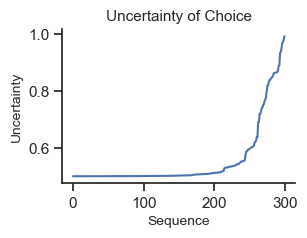

In [10]:
selected_sequences, uncertainty = interp.get_uncertain_sequences(sequences, model, feature='choice', is_uncertain=True, threshold=0)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(uncertainty)
ax.set(title='Uncertainty of Choice', xlabel='Sequence', ylabel='Uncertainty')
sns.despine()

In [13]:
high_uncertainty_sequences, high_uncertainty = interp.get_uncertain_sequences(sequences, model, feature='choice', is_uncertain=True, threshold=0.7)
print(high_uncertainty_sequences[:10])

low_uncertainty_sequences, low_uncertainty = interp.get_uncertain_sequences(sequences, model, feature='choice', is_uncertain=False, threshold=0.7)
print(low_uncertainty_sequences[:10])


['LLLlLr', 'llllll', 'LLLLlr', 'RRrLll', 'LLllRr', 'rlllll', 'Lllrrr', 'LLlRrr', 'rrrrrr', 'lrrrrr']
['RRRRRR', 'rRRRRR', 'LLLLLL', 'RrRRRR', 'RRRRrR', 'lLLLLL', 'RRRrRR', 'LLrLLL', 'RRrRRR', 'LLLrLL']


/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/core/utils.py:379: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_ordered = optimal_leaf_ordering(Z, square_distance)
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/core/utils.py:379: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_ordered = optimal_leaf_ordering(Z, square_distance)


Text(0.5, 0.98, 'Choice Uncertainty')

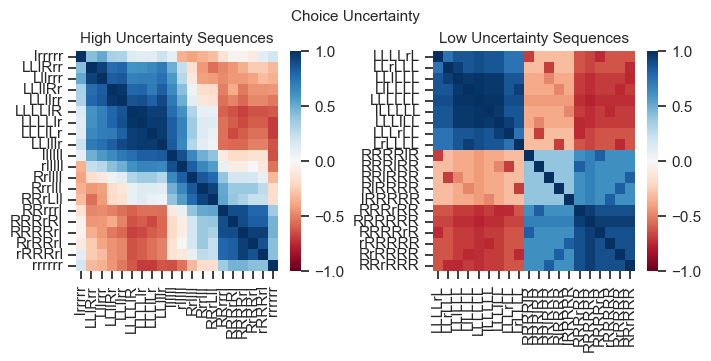

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), layout='constrained')

_, similarities = interp.sequence_embedding_similarity(model, high_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, high_uncertainty_sequences[:20], replot=False, is_similarity=True)
fig, axs[0] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, fig=fig, ax=axs[0])
axs[0].set(title='High Uncertainty Sequences')

_, similarities = interp.sequence_embedding_similarity(model, low_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, low_uncertainty_sequences[:20], replot=False, is_similarity=True)
fig, axs[1] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, fig=fig, ax=axs[1])
axs[1].set(title='Low Uncertainty Sequences')
fig.suptitle('Choice Uncertainty')


In [14]:
high_overall_uncertainty_sequences, high_overall_uncertainty = interp.get_uncertain_sequences(sequences, model, is_uncertain=True, threshold=0.5)
print(high_uncertainty_sequences[:10])

low_overall_uncertainty_sequences, low_overall_uncertainty = interp.get_uncertain_sequences(sequences, model, is_uncertain=False, threshold=0.7)
print(low_uncertainty_sequences[:10])


['LLLlLr', 'llllll', 'LLLLlr', 'RRrLll', 'LLllRr', 'rlllll', 'Lllrrr', 'LLlRrr', 'rrrrrr', 'lrrrrr']
['RRRRRR', 'rRRRRR', 'LLLLLL', 'RrRRRR', 'RRRRrR', 'lLLLLL', 'RRRrRR', 'LLrLLL', 'RRrRRR', 'LLLrLL']


/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/core/utils.py:379: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_ordered = optimal_leaf_ordering(Z, square_distance)
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/core/utils.py:379: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_ordered = optimal_leaf_ordering(Z, square_distance)


Text(0.5, 0.98, 'Overall Uncertainty (including reward)')

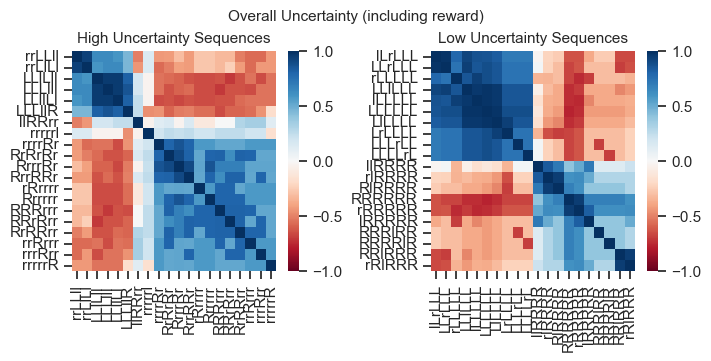

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), layout='constrained')

_, similarities = interp.sequence_embedding_similarity(model, high_overall_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, high_overall_uncertainty_sequences[:20], replot=False, is_similarity=True)
fig, axs[0] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, fig=fig, ax=axs[0])
axs[0].set(title='High Uncertainty Sequences')

_, similarities = interp.sequence_embedding_similarity(model, low_overall_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, low_overall_uncertainty_sequences[:20], replot=False, is_similarity=True)
fig, axs[1] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, fig=fig, ax=axs[1])
axs[1].set(title='Low Uncertainty Sequences')
fig.suptitle('Overall Uncertainty (including reward)')

Raw weights: N dimensions for each token (fixed at 4 right now, single letter vocab) and T positions (sequence length)

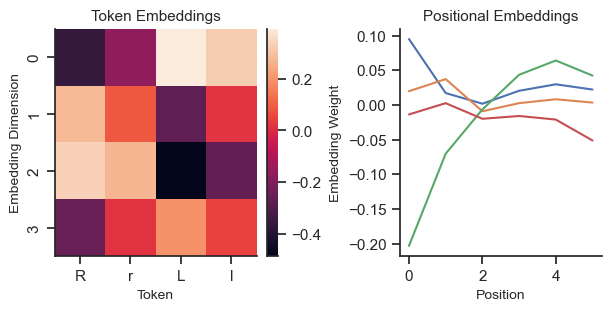

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 3), layout='constrained')
sns.heatmap(model.transformer.wte.weight.detach().cpu().numpy().T, ax=axs[0])
axs[0].set(title='Token Embeddings', xticklabels=vocab, xlabel='Token', ylabel='Embedding Dimension')
axs[1].plot(model.transformer.wpe.weight.detach().cpu().numpy())
axs[1].set(title='Positional Embeddings', xlabel='Position', ylabel='Embedding Weight')
sns.despine()


<Axes: >

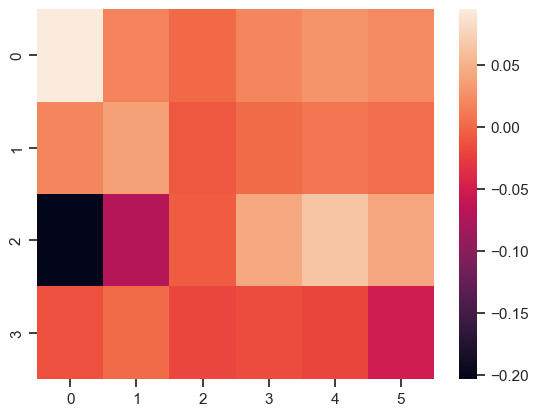

In [17]:
sns.heatmap(model.transformer.wpe.weight.detach().cpu().numpy().T)

### Starting by just looking at token embeddings
- What is the dimensionality of the token embeddings?
- Pairwise similarity between each of the token embeddings


Explained variance ratio: [9.4843531e-01 3.7498299e-02 1.4066368e-02 9.0830445e-16]
Cumulative explained variance: [0.9484353 0.9859336 1.        1.       ]


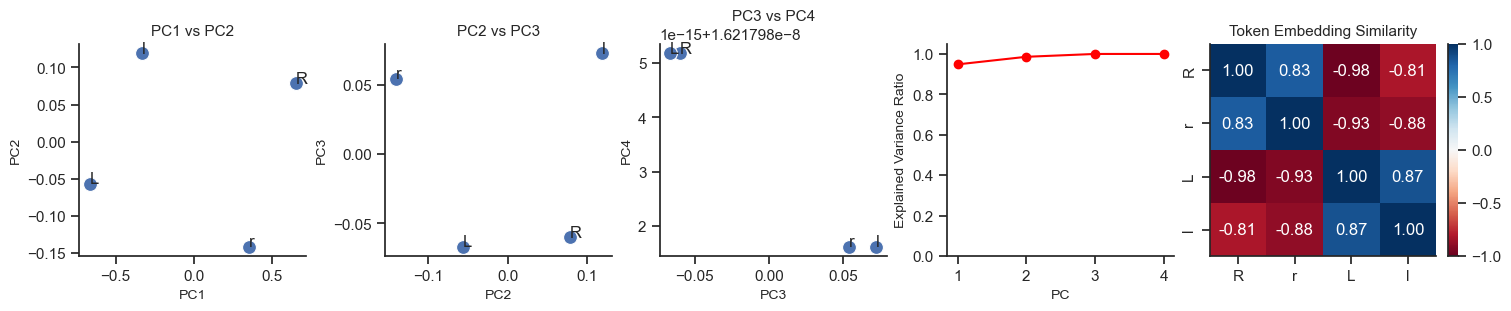

In [18]:
pca, embedded = interp.pca_embeddings(
    model, 
    n_components=4,
    token_mapping=stoi
)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

fig = plt.gcf()
fig_path = fm.get_experiment_file(f'embed_pca_tokens.png', run, subdir='interp')
fig.savefig(fig_path, bbox_inches='tight')

### Trajectory of learning this embedding space
Projecting token embeddings of each checkpoint into the embedding space (first 2 PCs) of the final trained model

Found 15 models for run 2


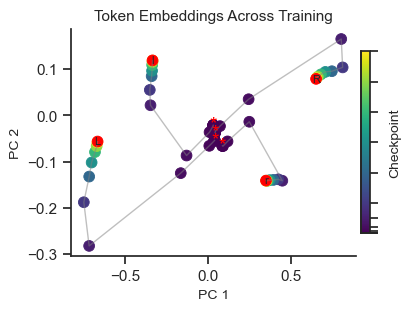

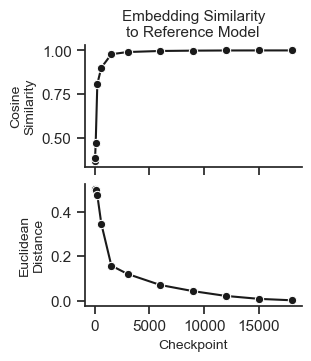

In [19]:
cp_data = interp.analyze_embedding_evolution(run)

In [56]:
sample_sequences = np.random.choice(sequences, size=20)

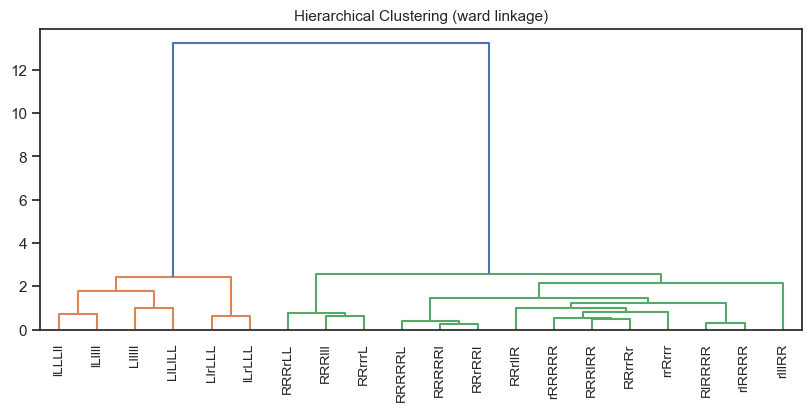

In [57]:
embeddings, similarities = interp.sequence_embedding_similarity(model, sample_sequences, stoi)

ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, sample_sequences, replot=False)

[Text(0.5, 1.0, 'run 36')]

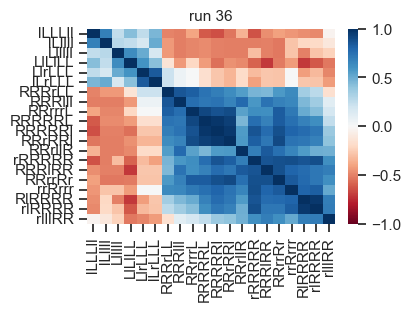

In [58]:
fig, ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences)
ax.set(title=f'run {run}')


### Sequence similarity for validation specific sequences

In [39]:
import evaluation.inspect_data as inspect

In [41]:
model_name = model_info['model_name']
train_events = parse.parse_simulated_data(*parse.get_data_filenames(run, suffix='tr'))
aligned_data = parse.load_predictions(run, model_name, suffix='v')

maxT = model_info['dataloader']['Sequence length (T)']
minT = maxT

aligned_data = inspect.compare_train_val(run, train_events, aligned_data,
                                 maxT=maxT, minT=minT, show_plot=False)

val_unique_sequences = aligned_data.query('seq6_overlap == False')['seq6_RL'].value_counts()[:20].index

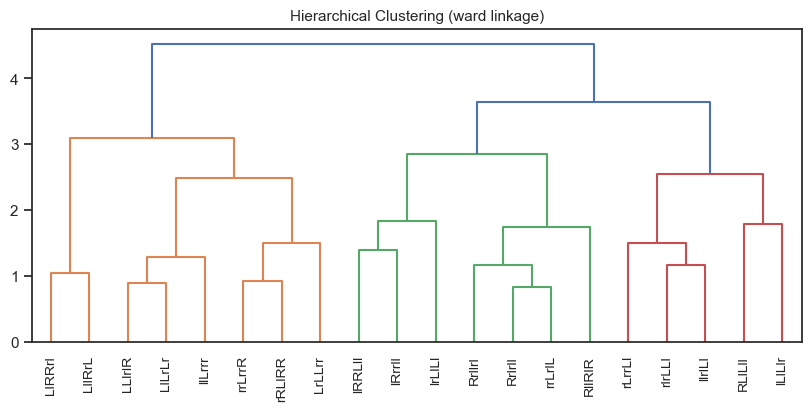

In [61]:
embeddings, similarities = interp.sequence_embedding_similarity(model, val_unique_sequences, stoi)

ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, val_unique_sequences, replot=False, is_similarity=True)

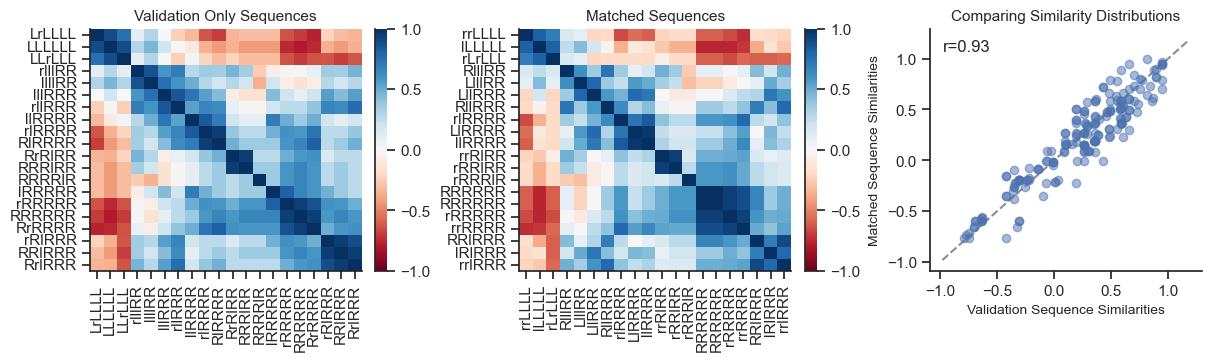

In [46]:
matched_sequences = inspect.match_by_base_sequence(aligned_data, ordered_sequences, base_T=5, min_count=20)

fig, axs = plt.subplots(ncols=3, figsize=(12, 3.5), layout='constrained')

fig, axs[0] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, fig=fig, ax=axs[0])
axs[0].set(title='Validation Only Sequences')

_, similarities = interp.sequence_embedding_similarity(model, matched_sequences, stoi)
fig, axs[1] = interp.plot_similarity(similarities, matched_sequences, fig=fig, ax=axs[1])
axs[1].set(title='Matched Sequences')

# Get upper triangular values (excluding diagonal) from both matrices
triu_idx = np.triu_indices_from(ordered_sim_matrix, k=1)
val_similarities = ordered_sim_matrix[triu_idx]

matched_sim_values = similarities[triu_idx]

# Plot the similarity values against each other
axs[2].scatter(val_similarities, matched_sim_values, alpha=0.5)
axs[2].set(xlabel='Validation Sequence Similarities', 
       ylabel='Matched Sequence Similarities',
       title='Comparing Similarity Distributions')

# Add diagonal line for reference
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
axs[2].plot(lims, lims, 'k--', alpha=0.5, zorder=0)
axs[2].text(lims[0], lims[1], f'r={np.corrcoef(val_similarities, matched_sim_values)[0, 1]:.2f}', ha='left', va='top', fontsize=12)
sns.despine()


## Comparing across different model architectures and task environments

Text(0.5, 0.98, 'Similarity Matrix (ordered by hierarchical clustering of first run)')

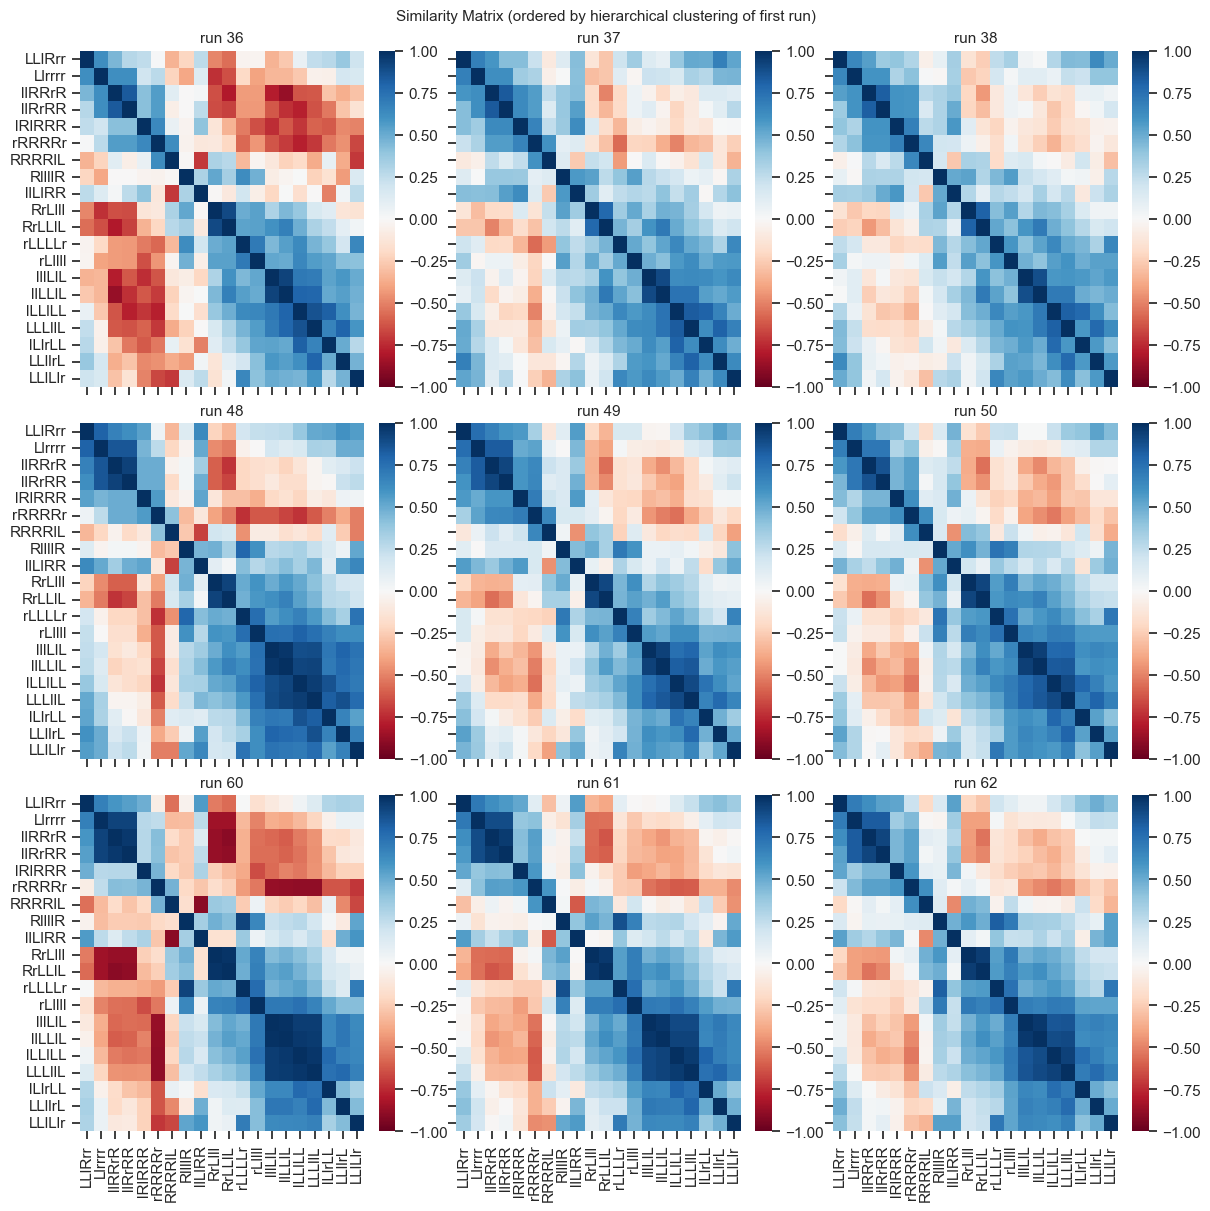

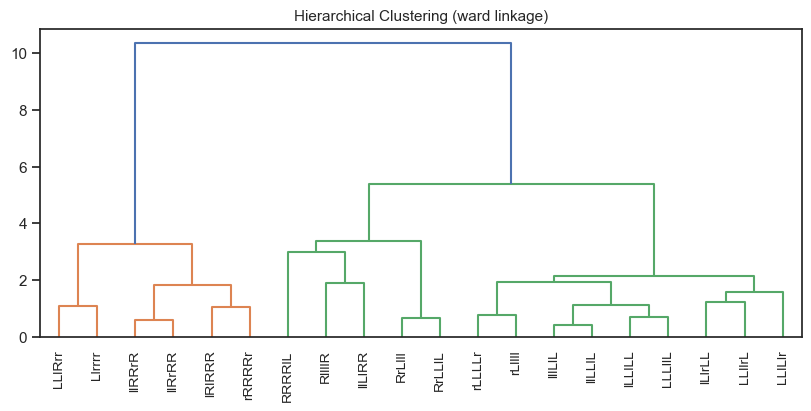

In [76]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12),
                        layout='constrained', sharex=True, sharey=True)

runs = [int(run.split('_')[1]) for run in os.listdir('../experiments') if run != '.DS_Store']

usable_runs = [36, 37, 38, 48, 49, 50, 60, 61, 62]
# usable_runs = []
if not usable_runs:
    for run in runs:
        model, model_info, config = parse.load_trained_model(run, model_name=None, device=device, weights_only=False)
        if T == model_info['dataloader']['Sequence length (T)']:
            usable_runs.append(run)
usable_runs = sorted(usable_runs)

for i, (run, ax) in enumerate(zip(usable_runs, axs.ravel())):

    model, model_info, config = parse.load_trained_model(run, model_name=None, device=device, weights_only=False)

    assert T == model_info['dataloader']['Sequence length (T)'], f"Sequence length mismatch for run {run}"
    events = parse.parse_simulated_data(*parse.get_data_filenames(run, suffix='v'))
    events = parse.add_sequence_columns(events, T)
    vc = events[f'seq{T}_RL'].value_counts()
    if i == 0:  # Use same sequences for all models
        sequences = vc[vc > 100].sample(n=20).index
        _, similarities = interp.sequence_embedding_similarity(model, sequences, stoi)
        ordered_sequences, ordered_sim_matrix, _ = interp.cluster_sequences_hierarchical(similarities, sequences, replot=False)
    else:
        _, ordered_sim_matrix = interp.sequence_embedding_similarity(model, ordered_sequences, stoi)

    ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
    ax.set(title=f'run {run}')

fig.suptitle('Similarity Matrix (ordered by hierarchical clustering of first run)')

In [77]:
usecols = [
    'model_id', 'domain_id',
       'num_samples', 'num_parameters', 'max_steps', 'run_number',
       'sequence_length', 'n_embd', 'epochs',
       'best_val_full_loss', 'best_val_full_loss_step', 'best_val_choice_loss',
       'best_val_choice_loss_step', 'best_val_reward_loss',
       'best_val_reward_loss_step'
]

model_summary = pd.read_csv('../model_summary.csv', usecols=usecols)
model_summary.query('sequence_length == 6')

model_summary.query('run_number in @usable_runs')[['run_number', 'model_id', 'domain_id', 'n_embd']]

,run_number,model_id,domain_id,n_embd
0,36,l1_h1_e100_c6_d4,A,4
1,37,l1_h1_e100_c6_d8,A,8
2,38,l1_h1_e100_c6_d16,A,16
12,48,l1_h1_e100_c6_d4,B,4
13,49,l1_h1_e100_c6_d8,B,8
14,50,l1_h1_e100_c6_d16,B,16
24,61,l1_h1_e100_c6_d8,C,8
25,62,l1_h1_e100_c6_d16,C,16
26,60,l1_h1_e100_c6_d4,C,4


In [ ]:
fig, ax = plt.subplots(figsize=(0.4 * len(ordered_sequences), 0.4 * len(ordered_sequences)),
                               layout='constrained')
ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
ax.set(title='Similarity Matrix (Ordered by Hierarchical Clustering)')

### Sequence through a block transition

In [235]:
# Get common sequences from data for analysis
num_sequences = 2000
N=1
events, sequences, counts = interp.get_common_sequences(T, run=run, events=events, k=num_sequences, min_count=N)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

Analyzing 2000 sequences:
['RRRRRR', 'LLLLLL', 'RRRRRr', 'LLLLLl', 'RRRRrR', 'LLLLlL', 'RRRrRR', 'RRrRRR', 'LLLlLL', 'RrRRRR', 'LLlLLL', 'rRRRRR', 'LlLLLL', 'lLLLLL', 'LLLLll', 'RRRRrr', 'RRRrRr', 'LLLlLl', 'RRrRRr', 'LLlLLl']


In [20]:
from interpretability.analyzers.activations import EmbeddingAnalyzer
from interpretability.core.config import DimensionalityReductionConfig

dr_config = DimensionalityReductionConfig(
    token_pos=-1,
    sequence_method='concat',
    n_components=4
)

analyzer = EmbeddingAnalyzer(model, config)
activations = analyzer.get_activations(sequences)
block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)
block_sequences = [list(b.values) for b in block_sequences]

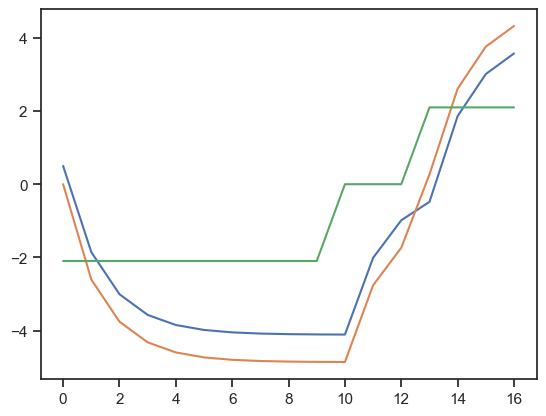

In [117]:
# from synthetic_data_generation.agent import RFLR_mouse
# from utils import parse_data

# events = parse_data.parse_passive_estimator_qlearning(run=run, events=events, suffix='tr')

# agent = RFLR_mouse(alpha=0.75, beta=2.1, tau=1.4)

# #################[L, L, L, L, L, L, l, L, L, l, l, l, l, l, l, l, l]
# sample_choices = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# sample_rewards = [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

# #################[L, L, L, L, L, L, L, L, L, L, l, l, r, R, R, R, R]
# sample_choices = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
# sample_rewards = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]

# phis, logodds, prights = agent.passive_estimator(sample_choices, sample_rewards)
# rpes, qs, logodds, pright = agent.passive_estimator_qlearning(sample_choices, sample_rewards)

# evidence_values = []
# for choice, reward in zip(sample_choices, sample_rewards):
#     evidence = agent.beta * (2 * choice - 1) * reward
#     evidence_values.append(evidence)

# plt.plot(phis)
# plt.plot(logodds)
# # plt.plot(prights)
# plt.plot(evidence_values)
# plt.plot(rpes)

In [21]:
num_sequences = 70
N=100
events, sequences, counts = interp.get_common_sequences(T, run=run, events=events, k=num_sequences, min_count=N)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

Analyzing 70 sequences:
['RRRRRR', 'LLLLLL', 'RRRRRr', 'LLLLLl', 'RRRRrR', 'LLLLlL', 'RRRrRR', 'RRrRRR', 'LLLlLL', 'RrRRRR', 'LLlLLL', 'rRRRRR', 'LlLLLL', 'lLLLLL', 'RRRRrr', 'LLLLll', 'RRRrRr', 'LLLlLl', 'RRrRRr', 'LLlLLl']


/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/core/base.py:563: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(


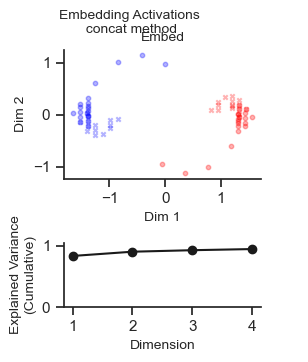

In [22]:
dr_config.sequence_method = 'concat'
fig, axs = analyzer.visualizer.plot_pca_by_layer(sequences, dr_config, alpha=0.3)

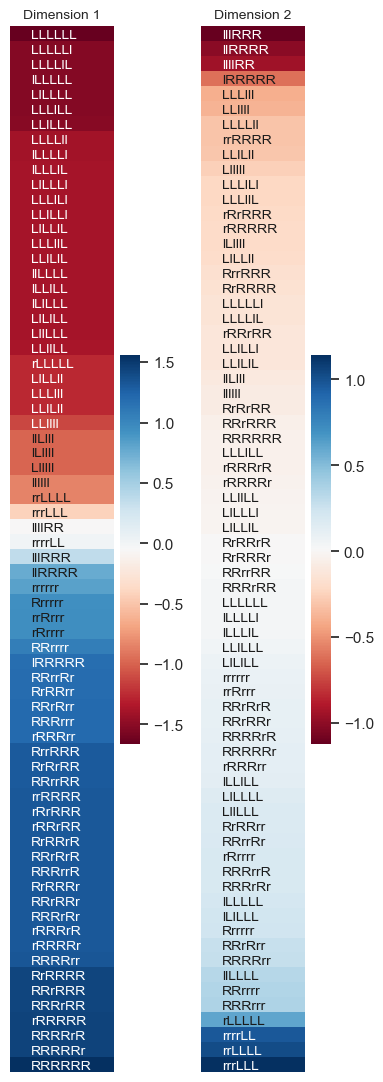

In [23]:
model, embeddings, seq_to_embedding = analyzer.compute_pca_embeddings(
    sequences,
    'embed',
    dr_config
)

fig, axs = plt.subplots(ncols=2, figsize=(4, 11))

dim0 = embeddings[:, 0]
dim0_sorted = np.argsort(dim0)
sequences_sorted = [sequences[i] for i in dim0_sorted]
dict(zip(sequences_sorted, dim0[dim0_sorted]))

dim_0_df = pd.Series(dict(zip(sequences_sorted, dim0[dim0_sorted])), name='dim0', index=sequences_sorted)
sns.heatmap(dim_0_df.values.reshape(-1, 1), ax=axs[0], cmap='RdBu')
# axs[0].set_yticks(np.arange(len(dim_0_df)) + 0.5)
# axs[0].set_yticklabels(dim_0_df.index.values, fontsize=10, rotation=0);
axs[0].set_yticks([],)
axs[0].set_xticks([])
[axs[0].annotate(s, (0.2, j+0.6), va='center', fontsize=10, color='k' if -1 < v < 1 else 'w')
 for j, (s, v) in enumerate(zip(dim_0_df.index.values, dim_0_df.values))]
axs[0].set_title('Dimension 1')

dim1 = embeddings[:, 1]
dim1_sorted = np.argsort(dim1)
sequences_sorted = [sequences[i] for i in dim1_sorted]
dict(zip(sequences_sorted, dim1[dim1_sorted]))

dim_1_df = pd.Series(dict(zip(sequences_sorted, dim1[dim1_sorted])), name='dim1', index=sequences_sorted)
sns.heatmap(dim_1_df.values.reshape(-1, 1), ax=axs[1], cmap='RdBu')
# axs[1].set_yticks(np.arange(len(dim_1_df)) + 0.5)
# axs[1].set_yticklabels(dim_1_df.index.values, fontsize=10, rotation=0);
axs[1].set_yticks([],)
axs[1].set_xticks([])
[axs[1].annotate(s, (0.2, j+0.6), va='center', fontsize=10, color='k' if -0.7 < v < 0.7 else 'w')
 for j, (s, v) in enumerate(zip(dim_1_df.index.values, dim_1_df.values))]
axs[1].set_title('Dimension 2')
plt.tight_layout()

/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/core/base.py:563: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/core/base.py:563: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(


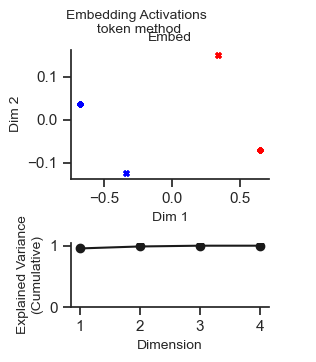

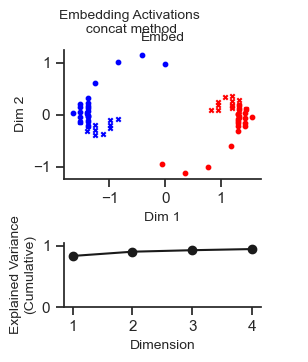

In [24]:
for sm in ['token', 'concat']:
    dr_config.sequence_method = sm
    fig, axs = analyzer.visualizer.plot_pca_by_layer(sequences, dr_config, counts=counts)
    fig_path = fm.get_experiment_file(f'embed_pca_{sm}.png', run, subdir=f'interp')
    # fig.savefig(fig_path, bbox_inches='tight')

In [25]:
block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)
block_trials = [list(b.index) for b in block_sequences]
c_trials = events.query('domain == "C"').trial_number.values
block_sequences_C = [list(b.values) for b in block_sequences if all(idx in c_trials for idx in b.index)]

a_trials = events.query('domain == "A"').trial_number.values
block_sequences_A = [list(b.values) for b in block_sequences if all(idx in a_trials for idx in b.index)]

/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:377: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(


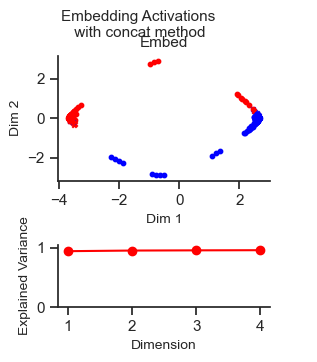

In [76]:
for sm in ['concat']:
    dr_config.sequence_method = sm
    fig, axs = analyzer.visualizer.plot_pca_by_layer(sequences, dr_config)
    fig_path = fm.get_experiment_file(f'embed_pca_{sm}.png', run, subdir=f'interp')
    # fig.savefig(fig_path, bbox_inches='tight')

In [ ]:
events, sequences, counts = interp.get_common_sequences(T, run, min_count=N, k=1000)

_, sequences_A, counts = interp.get_common_sequences(T, events=events.query('domain == "A"'), min_count=N, k=1000)

events, sequences, counts = interp.get_common_sequences(T, run, min_count=N, k=1000)
_, sequences_C, counts = interp.get_common_sequences(T, events=events.query('domain == "C"'), min_count=N, k=1000)


In [101]:
_, sequences_C, counts = interp.get_common_sequences(T, events=events.query('domain == "C"'), min_count=0, k=1000)


/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:377: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:377: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:377: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:377: UserWarning: No artists with lab

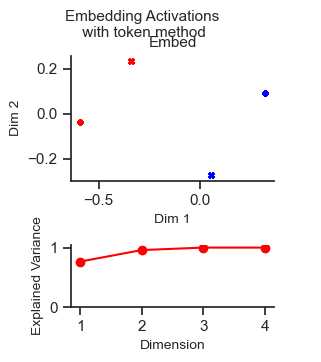

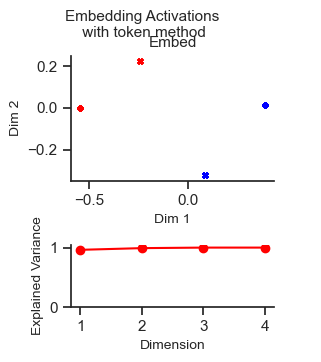

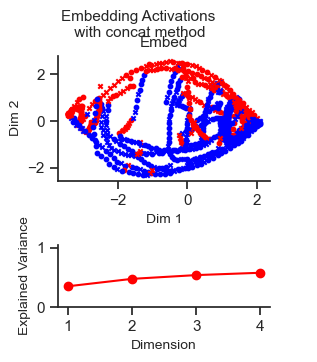

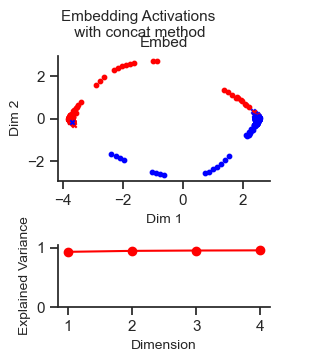

In [103]:
for sm in ['token', 'concat']:
    dr_config.sequence_method = sm
    fig, axs = analyzer.visualizer.plot_pca_by_layer(sequences_C, dr_config)
    fig_path = fm.get_experiment_file(f'embed_pca_{sm}_C.png', run, subdir=f'interp')
    fig.savefig(fig_path, bbox_inches='tight')

    fig, axs = analyzer.visualizer.plot_pca_by_layer(sequences_A, dr_config)
    fig_path = fm.get_experiment_file(f'embed_pca_{sm}_A.png', run, subdir=f'interp')
    fig.savefig(fig_path, bbox_inches='tight')

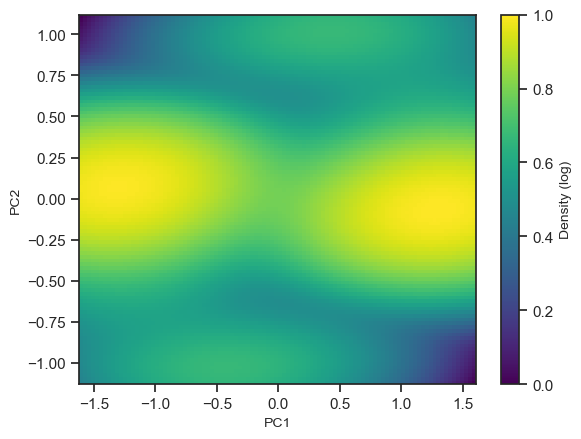

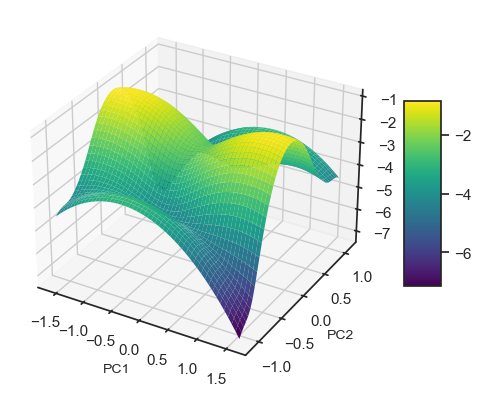

In [245]:
# 2D surface with log scaling to bring out low-density regions
fig, ax = plt.subplots()
analyzer.visualizer.plot_2d_surface(
    ax, embeddings, 
    method='kde',
    scale='log',           # Logarithmic scaling
    normalize=True         # Normalize to [0,1]
)
plt.show()

# 3D surface with sqrt scaling
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
analyzer.visualizer.plot_3d_surface(
    ax, embeddings,
    method='kde',
    scale='log',          # Square root scaling
    normalize=False        # Keep original range
)
plt.show()


In [ ]:

# Compare different scaling methods
scales = ['linear', 'log', 'sqrt', 'power']
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for ax, scale in zip(axs.ravel(), scales):
    analyzer.visualizer.plot_2d_surface(
        ax, embeddings,
        method='kde',
        scale=scale,
        normalize=True
    )
    ax.set_title(f'Scale: {scale}')
plt.tight_layout()
plt.show()

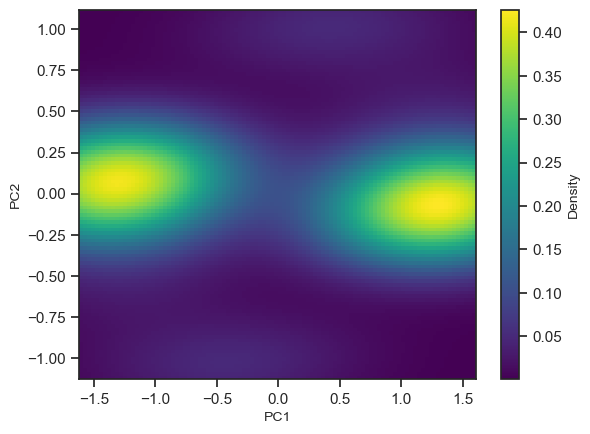

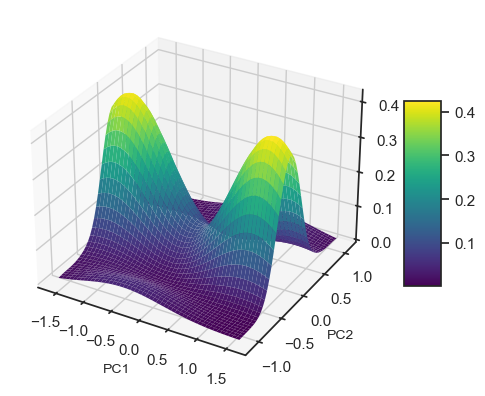

In [243]:
# 2D surface
fig, ax = plt.subplots()
analyzer.visualizer.plot_2d_surface(ax, embeddings, method='kde')  # or method='hist'
plt.show()

# 3D surface
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
analyzer.visualizer.plot_3d_surface(ax, embeddings, method='kde')
plt.show()

AttributeError: 'Axes' object has no attribute 'plot_surface'

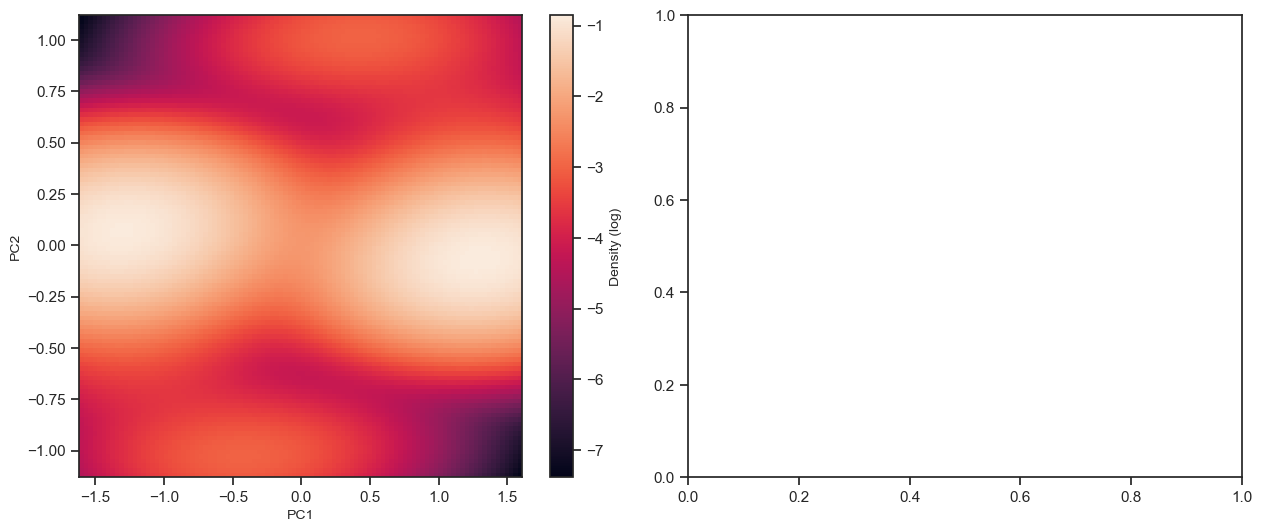

In [247]:
# Create subplots and use surface plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot
fig, ax1 = analyzer.visualizer.plot_2d_surface(
    embeddings, 
    ax=ax1,
    method='kde',
    scale='log'
)

# Second subplot
fig, ax2 = analyzer.visualizer.plot_3d_surface(
    embeddings, 
    ax=ax2,
    method='hist',
    scale='sqrt'
)

plt.tight_layout()

In [ ]:

# Compare different methods
methods = ['density', 'contour', 'heatmap']
for method in methods:
    fig, axs = analyzer.plot_pca_surface_by_layer(
        sequences, config, 
        surface_method=method
    )
    plt.show()

# Customize density surface
fig, axs = analyzer.plot_pca_surface_by_layer(
    sequences, config,
    surface_method='density',
    bins=100,        # More bins = finer resolution
    smoothing=2.0    # More smoothing = smoother surface
)

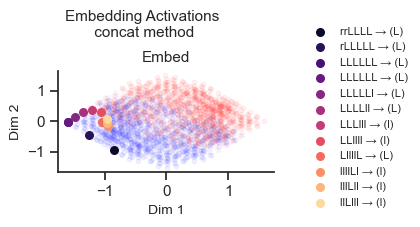

In [237]:
for i, seq in enumerate(block_sequences[1:2], start=10):
    fig, axs = analyzer.visualizer.plot_pca_across_trials(sequences, seq, 'embed', dr_config)
    fig_path = fm.get_experiment_file(f'embed_pca_concat.png', run, subdir=f'interp/bt_{i}')
    # fig.savefig(fig_path, bbox_inches='tight')

In [56]:
events, sequences, counts = interp.get_common_sequences(T, events=events, min_count=N, k=1000)
activations = analyzer.get_activations(sequences)
last_pos_by_layer = analyzer.get_activation_by_position(activations, token_pos=-1)

In [57]:
# Find maximal activations for each layer
max_activations = {}

for layer_name in analyzer.layers:
    max_activations[layer_name] = analyzer.find_maximal_activations(
        last_pos_by_layer, layer_name, sequences)
    
    # Print example results for a few neurons
    print(f"\n{layer_name.upper()} LAYER - Top activating sequences:")
    for neuron_idx in range(min(5, len(max_activations[layer_name]))):  # Show first 5 neurons
        print(f"Neuron {neuron_idx}: ", end="")
        for seq, act in max_activations[layer_name][neuron_idx][:5]:
            print(f"{seq} ({act:.3f})", end=" | ")
        print()


EMBED LAYER - Top activating sequences:
Neuron 0: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr (0.198) | RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRrr (0.198) | RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRrrr (0.198) | LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLr (0.198) | RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRrRRRRRRRRRRRRRRRRr (0.198) | 
Neuron 1: LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL (0.403) | LLLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL (0.403) | LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLlL (0.403) | LLLLLlLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL (0.403) | LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLlLLLL (0.403) | 
Neuron 2: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR (-0.003) | RrRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR (-0.003) | RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRrRRRRRRR (-0.003) | RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRrRRRRRRRRR (-0.003) | RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRrRRRRRRRR (-0.003) | 
Neuron 3: RRRRRRRRRRRRRRRRRRRRRRRRRR

In [61]:
analyzer.n_embd

32

Neuron 1
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR--r
Neuron 2
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Neuron 3
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
Neuron 4
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRr
Neuron 5
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
Neuron 6
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
Neuron 7
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Neuron 8
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
Neuron 9
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Neuron 10
RRRRRRRRRRRRRRRRRRRRRRRRRRR

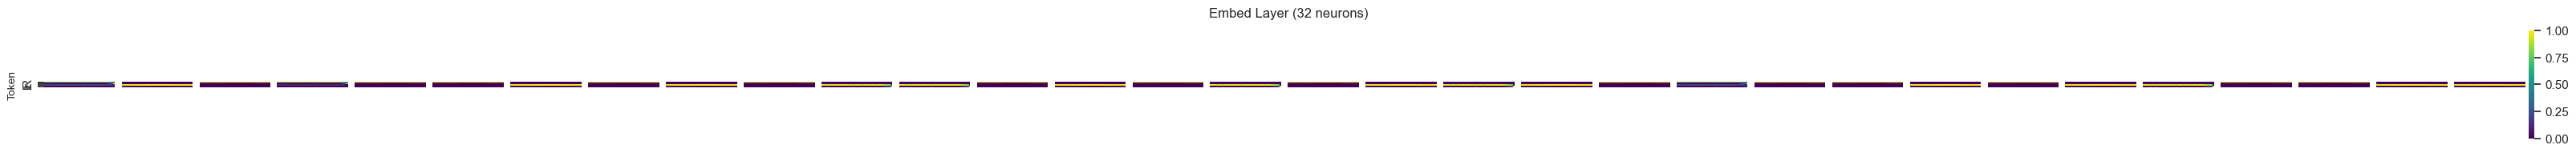

In [62]:
fig, axes_dict = analyzer.visualizer.create_mlp_visualization()

for neuron_idx, ax in enumerate(axes_dict['embed']):
    ax, token_counts = analyzer.analyze_neuron_patterns(max_activations, layer_name, neuron_idx, verbose=False,
                                                        ax=ax, cbar=neuron_idx == (len(axes_dict['embed'])-1))
    avg_sequence = analyzer.get_average_sequence(token_counts, single_threshold=0, joint_threshold=0)
    avg_sequence_thresholded = analyzer.get_average_sequence(token_counts, single_threshold=0.6, joint_threshold=0.4)
    if T < 10:
        ax.set(title=f"Neuron {neuron_idx+1}\n{avg_sequence}\n{avg_sequence_thresholded}", xticks=[])
    else:
        ax.set(title='', xticks=[])
        print(f"Neuron {neuron_idx+1}\n{avg_sequence}\n{avg_sequence_thresholded}")
    ax.set_aspect(1)
    if neuron_idx > 0:
        ax.set(ylabel='', yticks=[])
    ax.set(xlabel='')

fig_path = fm.get_experiment_file(f'embed_max_act.png', run, subdir='interp')
fig.savefig(fig_path, bbox_inches='tight')